In [ ]:
import random
from collections import defaultdict
import matplotlib.pyplot as plt
from diceville_game import Game, Player, BuildingType, SurfaceType, Floor

class Bot:
    def __init__(self, strategy, player):
        self.strategy = strategy
        self.player = player

    def play_turn(self, game):
        game.player_throw_dice()

        action_count = 0

        while game.game_moves_system.can_make_move():
            success = False
            if self.strategy == 1:
                success = self.max_income_strategy(game)
            elif self.strategy == 2:
                success = self.min_action_max_floor(game)
            elif self.strategy == 3:
                success = self.random_strategy(game)
            elif self.strategy == 4:
                success = self.min_money_start_floor(game, action_count)
            elif self.strategy == 5:
                success = self.min_money_second_floor(game, action_count)
            if success:
                game.game_moves_system.make_move()
            else:
                break  # Действие не выполнено, завершить ход
            action_count += 1

    def try_buy_floor(self, game):
        player = self.player
        main_base = game.get_main_building_for_player(player)
        affordable_floors = [i for i in range(len(main_base.floors)) if not main_base.floors[i].is_active and game.player_money[player] >= main_base.floors[i].price]
        if affordable_floors:
            floor_id = random.choice(affordable_floors)
            game.buy_floor(player, floor_id)
            return True
        return False

    def try_build(self, game):
        player = self.player
        hand = game.player_hand_of_cards[player].hand
        available_tiles = game.get_all_available_for_build_map_tiles_for_player(player)
        if not available_tiles:
            return False
        candidates = []
        for card_id, card in enumerate(hand):
            if card and game.can_player_purchase_building(player, card):
                suitable_tiles = [t for t in available_tiles if t.surface == card.requirement_tile_surface or card.requirement_tile_surface == SurfaceType.ANY]
                if suitable_tiles:
                    candidates.append((card_id, card, suitable_tiles))
        if candidates:
            card_id, card, suitable_tiles = random.choice(candidates)
            tile = random.choice(suitable_tiles)
            building = game.player_hand_of_cards[player].use_building(card_id)
            game.builder_on_tile.set_building_for_build_on_tile(building, tile, player)
            return True
        return False

    def try_buy_tile(self, game):
        player = self.player
        possible_positions = self.get_possible_buy_tiles(game, player)
        if possible_positions and game.player_money[player] >= game.get_buy_tile_cost(player):
            pos = random.choice(possible_positions)
            game.buy_tile(player, pos)
            return True
        return False

    def try_replace_card(self, game):
        player = self.player
        hand = game.player_hand_of_cards[player]
        if hand.ability_to_replace_card_count > 0:
            card_id = random.randint(0, 5)
            if hand.hand[card_id]:
                hand.replace_card(card_id)
                return True
        return False

    def get_possible_buy_tiles(self, game, player):
        own_positions = [t.position for t in game.get_all_map_tiles_for_player(player)]
        possible = []
        for x in range(game.game_map.size[0]):
            for y in range(game.game_map.size[1]):
                tile = game.game_map.map[x][y]
                if tile.owner == Player.NULL and tile.building is None:
                    for ox, oy in own_positions:
                        if abs(x - ox) + abs(y - oy) == 1:
                            possible.append((x, y))
                            break
        return possible

    def max_income_strategy(self, game):
        # Стратегия 1: Строить здания с высоким доходом, если доход > 3
        player = self.player
        hand = game.player_hand_of_cards[player].hand
        available_tiles = game.get_all_available_for_build_map_tiles_for_player(player)
        if not available_tiles:
            return self.try_buy_floor(game) or self.try_buy_tile(game)
        candidates = []
        for card_id, card in enumerate(hand):
            if card and game.can_player_purchase_building(player, card) and card.get_income_in_case_of_invoke(game) > 3:
                suitable_tiles = [t for t in available_tiles if t.surface == card.requirement_tile_surface or card.requirement_tile_surface == SurfaceType.ANY]
                if suitable_tiles:
                    candidates.append((card_id, card, suitable_tiles))
        if candidates:
            card_id, card, suitable_tiles = max(candidates, key=lambda x: x[1].get_income_in_case_of_invoke(game))
            tile = random.choice(suitable_tiles)
            building = game.player_hand_of_cards[player].use_building(card_id)
            game.builder_on_tile.set_building_for_build_on_tile(building, tile, player)
            return True
        return self.try_buy_floor(game) or self.try_buy_tile(game)

    def min_action_max_floor(self, game):
        # Стратегия 2: Попытаться купить этаж, минимизировать действия
        if self.try_buy_floor(game):
            return True
        
        return self.try_build(game) or self.try_buy_tile(game) or self.try_replace_card(game)

    def random_strategy(self, game):
        # Стратегия 3: Случайное действие
        actions = [self.try_buy_floor, self.try_build, self.try_buy_tile, self.try_replace_card]
        random.shuffle(actions)
        for action in actions:
            if action(game):
                return True
        return False

    def min_money_start_floor(self, game, action_count):
        # Стратегия 4: Начать с покупки этажа, затем тратить деньги
        if action_count == 0:
            return self.try_buy_floor(game)
        else:
            return self.try_build(game) or self.try_buy_tile(game)

    def min_money_second_floor(self, game, action_count):
        # Стратегия 5: Сначала не этаж, второй - этаж, затем тайлы
        if action_count == 0:
            return self.try_build(game) or self.try_buy_tile(game)
        else:
            return self.try_buy_floor(game) or self.try_buy_tile(game)

def run_trials(num_games=10):
    strategies = [1, 2, 3, 4]  # Стратегии 1-4 для 4 игроков; для 5 заменить одну
    wins = defaultdict(int)
    game_winners = []

    for game_num in range(num_games):
        game = Game(num_players=4)
        bots = {game.players[i]: Bot(strategies[i], game.players[i]) for i in range(4)}

        turn_count = 0
        while not game.is_game_over and turn_count < 10000:  # Предотвратить бесконечный цикл
            player = game.game_moves_system.get_current_turn_player()
            bots[player].play_turn(game)
            game.game_moves_system.make_turn()
            turn_count += 1

        # Найти победителя
        for player in game.players:
            main_base = game.get_main_building_for_player(player)
            if main_base.get_count_of_activated_floors() == 7:
                winner_strategy = bots[player].strategy
                wins[winner_strategy] += 1
                game_winners.append((game_num + 1, winner_strategy))
                break

    print("Результаты игр:")
    for game_num, winner in game_winners:
        print(f"Игра {game_num}: Победила стратегия {winner}")

    print("\nИтог:")
    for strat, count in wins.items():
        print(f"Стратегия {strat}: {count} побед")

    # Анализ: Winrate каждой стратегии
    all_strategies = {i: wins[i] for i in strategies}
    winrates = {strat: (count / num_games * 100) for strat, count in all_strategies.items()}
    print("\nWinrate стратегий:")
    for strat, wr in winrates.items():
        print(f"Стратегия {strat}: {wr:.2f}%")

    # Более информативная диаграмма
    fig, ax = plt.subplots(figsize=(12, 8))
    bars = ax.bar(winrates.keys(), winrates.values(), color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'], 
                   edgecolor='black', linewidth=1.2, alpha=0.8)
    ax.set_xlabel('Стратегия', fontsize=12, fontweight='bold')
    ax.set_ylabel('Winrate (%)', fontsize=12, fontweight='bold')
    ax.set_title('Winrate стратегий ботов в симуляции игр\n(Количество игр: {}, Общее побед: {})'.format(num_games, sum(wins.values())), 
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(range(1, 5))
    ax.set_xticklabels(['Стратегия 1\n(Максимизация инкама)', 'Стратегия 2\n(Мин. действий + этажи)', 
                        'Стратегия 3\n(Рандом)', 'Стратегия 4\n(Мин. денег + этаж сначала)'], rotation=0, ha='center')

    # Добавление значений на бары
    for bar, (strat, wr) in zip(bars, winrates.items()):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{wr:.1f}%\n({wins[strat]} побед)', ha='center', va='bottom', 
                fontsize=10, fontweight='bold', color='black')

    # Добавление сетки
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    # Легенда с описаниями
    legend_labels = ['Стратегия 1: Максимизация инкама\n(Фокус на высокодоходных зданиях)', 
                     'Стратегия 2: Максимизация трат очков действий + стараться покупать этажи в каждый ход\n(Приоритет покупке этажей)', 
                     'Стратегия 3: Рандом\n(Полнейший рандом)', 
                     'Стратегия 4: Минимизация коилчества денег, которые остаются в конце хода, но каждой действие начинается с покупки этажа']
    ax.legend(bars, legend_labels, loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

    # Добавление аннотации с общим анализом
    textstr = f'Общее количество игр: {num_games}\n' \
              f'Средний winrate: {sum(winrates.values())/len(winrates):.1f}%'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.show()

# Запуск
run_trials(1000)

IndexError: list index out of range

Player Player.ENEMY2 wins!
Player Player.ENEMY3 wins!
Player Player.ENEMY1 wins!
Player Player.ENEMY1 wins!
Player Player.ENEMY1 wins!
Player Player.ENEMY3 wins!
Player Player.ENEMY1 wins!
Player Player.ENEMY2 wins!
Player Player.ENEMY1 wins!
Player Player.ENEMY1 wins!

Итог:
Стратегия 3: 2 побед
Стратегия 4: 2 побед
Стратегия 2: 6 побед

Winrate стратегий:
Стратегия 1: 0.00%
Стратегия 2: 60.00%
Стратегия 3: 20.00%
Стратегия 4: 20.00%

Таблица результатов игр:
 Номер игры  Стратегия победителя
          1                     3
          2                     4
          3                     2
          4                     2
          5                     2
          6                     4
          7                     2
          8                     3
          9                     2
         10                     2


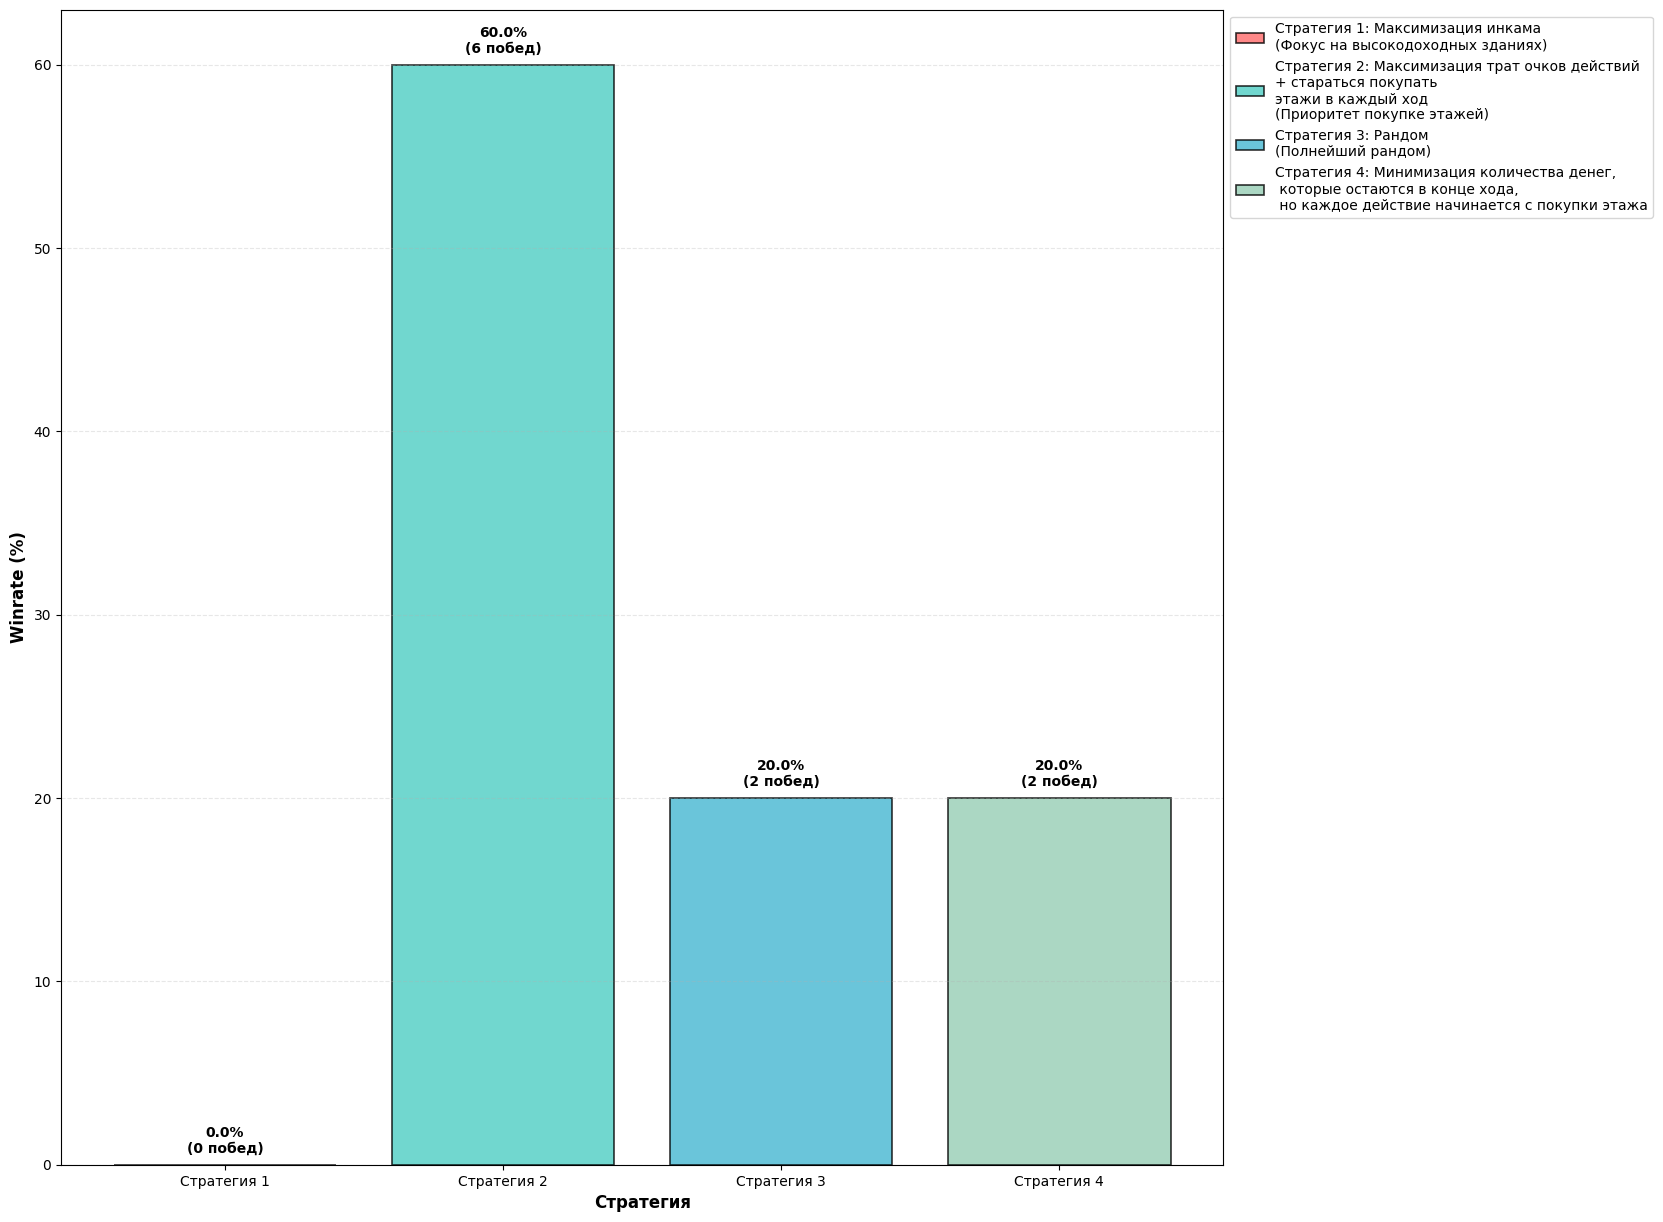

In [5]:
import random
from collections import defaultdict
import matplotlib.pyplot as plt
from diceville_game import Game, Player, BuildingType, SurfaceType, Floor
import pandas as pd 

class Bot:
    def __init__(self, strategy, player):
        self.strategy = strategy
        self.player = player

    def play_turn(self, game):
        game.player_throw_dice()

        action_count = 0

        while game.game_moves_system.can_make_move():
            success = False
            if self.strategy == 1:
                success = self.max_income_strategy(game)
            elif self.strategy == 2:
                success = self.min_action_max_floor(game)
            elif self.strategy == 3:
                success = self.random_strategy(game)
            elif self.strategy == 4:
                success = self.min_money_start_floor(game, action_count)
            elif self.strategy == 5:
                success = self.min_money_second_floor(game, action_count)
            if success:
                game.game_moves_system.make_move()
            else:
                break  # Действие не выполнено, завершить ход
            action_count += 1

    def try_buy_floor(self, game):
        player = self.player
        main_base = game.get_main_building_for_player(player)
        affordable_floors = [i for i in range(len(main_base.floors)) if not main_base.floors[i].is_active and game.player_money[player] >= main_base.floors[i].price]
        if affordable_floors:
            floor_id = random.choice(affordable_floors)
            game.buy_floor(player, floor_id)
            return True
        return False

    def try_build(self, game):
        player = self.player
        hand = game.player_hand_of_cards[player].hand
        available_tiles = game.get_all_available_for_build_map_tiles_for_player(player)
        if not available_tiles:
            return False
        candidates = []
        for card_id, card in enumerate(hand):
            if card and game.can_player_purchase_building(player, card):
                suitable_tiles = [t for t in available_tiles if t.surface == card.requirement_tile_surface or card.requirement_tile_surface == SurfaceType.ANY]
                if suitable_tiles:
                    candidates.append((card_id, card, suitable_tiles))
        if candidates:
            card_id, card, suitable_tiles = random.choice(candidates)
            tile = random.choice(suitable_tiles)
            building = game.player_hand_of_cards[player].use_building(card_id)
            game.builder_on_tile.set_building_for_build_on_tile(building, tile, player)
            return True
        return False

    def try_buy_tile(self, game):
        player = self.player
        possible_positions = self.get_possible_buy_tiles(game, player)
        if possible_positions and game.player_money[player] >= game.get_buy_tile_cost(player):
            pos = random.choice(possible_positions)
            game.buy_tile(player, pos)
            return True
        return False

    def try_replace_card(self, game):
        player = self.player
        hand = game.player_hand_of_cards[player]
        if hand.ability_to_replace_card_count > 0:
            card_id = random.randint(0, 5)
            if hand.hand[card_id]:
                hand.replace_card(card_id)
                return True
        return False

    def get_possible_buy_tiles(self, game, player):
        own_positions = [t.position for t in game.get_all_map_tiles_for_player(player)]
        possible = []
        for x in range(game.game_map.size[0]):
            for y in range(game.game_map.size[1]):
                tile = game.game_map.map[x][y]
                if tile.owner == Player.NULL and tile.building is None:
                    for ox, oy in own_positions:
                        if abs(x - ox) + abs(y - oy) == 1:
                            possible.append((x, y))
                            break
        return possible

    def max_income_strategy(self, game):
        # Стратегия 1: Максимизация инкама (Фокус на высокодоходных зданиях)
        player = self.player
        hand = game.player_hand_of_cards[player].hand
        available_tiles = game.get_all_available_for_build_map_tiles_for_player(player)
        if not available_tiles:
            return self.try_buy_floor(game) or self.try_buy_tile(game)
        candidates = []
        for card_id, card in enumerate(hand):
            if card and game.can_player_purchase_building(player, card) and card.get_income_in_case_of_invoke(game) > 3:
                suitable_tiles = [t for t in available_tiles if t.surface == card.requirement_tile_surface or card.requirement_tile_surface == SurfaceType.ANY]
                if suitable_tiles:
                    candidates.append((card_id, card, suitable_tiles))
        if candidates:
            card_id, card, suitable_tiles = max(candidates, key=lambda x: x[1].get_income_in_case_of_invoke(game))
            tile = random.choice(suitable_tiles)
            building = game.player_hand_of_cards[player].use_building(card_id)
            game.builder_on_tile.set_building_for_build_on_tile(building, tile, player)
            return True
        return self.try_buy_floor(game) or self.try_buy_tile(game) or self.try_replace_card(game)

    def min_action_max_floor(self, game):
        # Стратегия 2: Максимизация трат очков действий + стараться покупать этажи в каждый ход (Приоритет покупке этажей)
        return self.try_buy_floor(game) or self.try_build(game) or self.try_buy_tile(game) or self.try_replace_card(game)

    def random_strategy(self, game):
        # Стратегия 3: Рандом (Полнейший рандом)
        actions = [self.try_buy_floor, self.try_build, self.try_buy_tile, self.try_replace_card]
        random.shuffle(actions)
        for action in actions:
            if action(game):
                return True
        return False

    def min_money_start_floor(self, game, action_count):
        # Стратегия 4: Минимизация количества денег, которые остаются в конце хода, но каждое действие начинается с покупки этажа
        if self.try_buy_floor(game):
            return True
        return self.try_build(game) or self.try_buy_tile(game)

    def min_money_second_floor(self, game, action_count):
        # Стратегия 5: Каждое действие начинается не с постройки главного здания, но вторым действие идет постройка главного здания (минимизация денег), если остались деньги и есть возможность покупка тайлов
        if action_count % 2 == 1:  # Для нечетных (второй, четвертый и т.д.)
            return self.try_buy_floor(game) or self.try_buy_tile(game)
        else:
            return self.try_build(game) or self.try_buy_tile(game)

def run_trials(num_games=10):
    # Use only available players (assuming max 4 based on enum)
    max_players = 4
    strategies = [1, 2, 3, 4]  # Limit to 4 strategies for 4 players
    wins = defaultdict(int)
    game_winners = []

    for game_num in range(num_games):
        game = Game(num_players=max_players)
        bots = {game.players[i]: Bot(strategies[i], game.players[i]) for i in range(max_players)}

        turn_count = 0
        while not game.is_game_over and turn_count < 10000:  # Предотвратить бесконечный цикл
            player = game.game_moves_system.get_current_turn_player()
            bots[player].play_turn(game)
            game.game_moves_system.make_turn()
            turn_count += 1

        # Найти победителя
        for player in game.players:
            main_base = game.get_main_building_for_player(player)
            if main_base.get_count_of_activated_floors() == 7:
                winner_strategy = bots[player].strategy
                wins[winner_strategy] += 1
                game_winners.append((game_num + 1, winner_strategy))
                break

    #print("Результаты игр:")
    #for game_num, winner in game_winners:
    #    print(f"Игра {game_num}: Победила стратегия {winner}")

    print("\nИтог:")
    for strat, count in wins.items():
        print(f"Стратегия {strat}: {count} побед")

    # Анализ: Winrate каждой стратегии
    all_strategies = {i: wins[i] for i in strategies}
    winrates = {strat: (count / num_games * 100) for strat, count in all_strategies.items()}
    print("\nWinrate стратегий:")
    for strat, wr in winrates.items():
        print(f"Стратегия {strat}: {wr:.2f}%")

    results_df = pd.DataFrame(game_winners, columns=['Номер игры', 'Стратегия победителя'])
    print("\nТаблица результатов игр:")
    print(results_df.to_string(index=False))

    # Более информативная диаграмма
    fig, ax = plt.subplots(figsize=(15, 15))
    bars = ax.bar(winrates.keys(), winrates.values(), color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'], 
                   edgecolor='black', linewidth=1.2, alpha=0.8)
    ax.set_xlabel('Стратегия', fontsize=12, fontweight='bold')
    ax.set_ylabel('Winrate (%)', fontsize=12, fontweight='bold')
    ax.set_xticks(range(1, 5))
    ax.set_xticklabels(['Стратегия 1', 'Стратегия 2', 
                        'Стратегия 3', 'Стратегия 4'], rotation=0, ha='center')

    # Добавление значений на бары
    for bar, (strat, wr) in zip(bars, winrates.items()):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{wr:.1f}%\n({wins[strat]} побед)', ha='center', va='bottom', 
                fontsize=10, fontweight='bold', color='black')

    # Добавление сетки
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    # Легенда с описаниями
    legend_labels = ['Стратегия 1: Максимизация инкама\n(Фокус на высокодоходных зданиях)', 
                     'Стратегия 2: Максимизация трат очков действий\n+ стараться покупать\nэтажи в каждый ход\n(Приоритет покупке этажей)', 
                     'Стратегия 3: Рандом\n(Полнейший рандом)', 
                     'Стратегия 4: Минимизация количества денег,\n которые остаются в конце хода,\n но каждое действие начинается с покупки этажа']
    ax.legend(bars, legend_labels, loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

    plt.show()

# Запуск
run_trials(10)

Player Player.ENEMY1 wins!
Player Player.ENEMY2 wins!
Player Player.ENEMY2 wins!
Player Player.ENEMY1 wins!
Player Player.ENEMY3 wins!
Player Player.ENEMY3 wins!
Player Player.ENEMY3 wins!
Player Player.ENEMY1 wins!
Player Player.ENEMY3 wins!
Player Player.ENEMY2 wins!

Итог:
Стратегия 2: 3 побед
Стратегия 3: 3 побед
Стратегия 5: 4 побед

Winrate стратегий:
Стратегия 1: 0.00%
Стратегия 2: 30.00%
Стратегия 3: 30.00%
Стратегия 5: 40.00%

Таблица результатов игр:
 Номер игры  Стратегия победителя
          1                     2
          2                     3
          3                     3
          4                     2
          5                     5
          6                     5
          7                     5
          8                     2
          9                     5
         10                     3


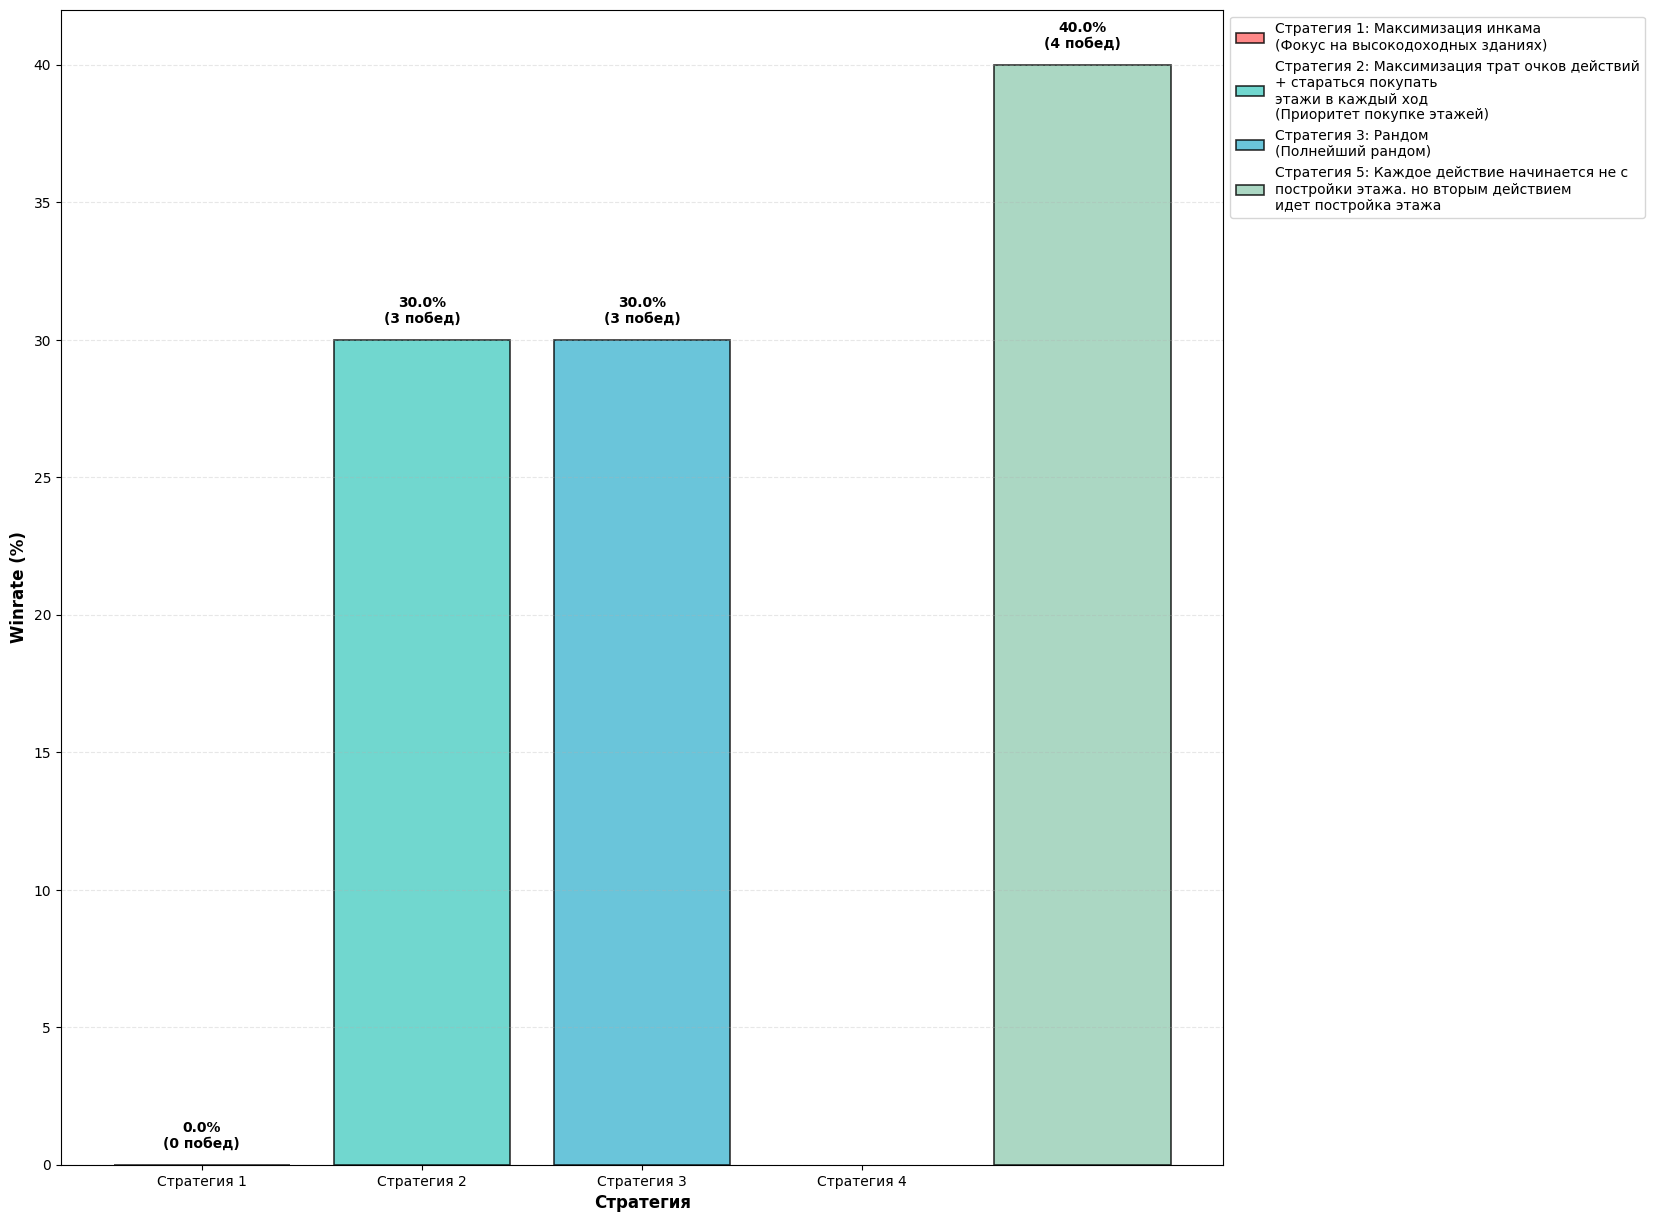

In [9]:
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd 
from diceville_game import Game, Player, BuildingType, SurfaceType, Floor

class Bot:
    def __init__(self, strategy, player):
        self.strategy = strategy
        self.player = player

    def play_turn(self, game):
        game.player_throw_dice()

        action_count = 0

        while game.game_moves_system.can_make_move():
            success = False
            if self.strategy == 1:
                success = self.max_income_strategy(game)
            elif self.strategy == 2:
                success = self.min_action_max_floor(game)
            elif self.strategy == 3:
                success = self.random_strategy(game)
            elif self.strategy == 4:
                success = self.min_money_start_floor(game, action_count)
            elif self.strategy == 5:
                success = self.min_money_second_floor(game, action_count)
            if success:
                game.game_moves_system.make_move()
            else:
                break  # Действие не выполнено, завершить ход
            action_count += 1

    def try_buy_floor(self, game):
        player = self.player
        main_base = game.get_main_building_for_player(player)
        affordable_floors = [i for i in range(len(main_base.floors)) if not main_base.floors[i].is_active and game.player_money[player] >= main_base.floors[i].price]
        if affordable_floors:
            floor_id = random.choice(affordable_floors)
            game.buy_floor(player, floor_id)
            return True
        return False

    def try_build(self, game):
        player = self.player
        hand = game.player_hand_of_cards[player].hand
        available_tiles = game.get_all_available_for_build_map_tiles_for_player(player)
        if not available_tiles:
            return False
        candidates = []
        for card_id, card in enumerate(hand):
            if card and game.can_player_purchase_building(player, card):
                suitable_tiles = [t for t in available_tiles if t.surface == card.requirement_tile_surface or card.requirement_tile_surface == SurfaceType.ANY]
                if suitable_tiles:
                    candidates.append((card_id, card, suitable_tiles))
        if candidates:
            card_id, card, suitable_tiles = random.choice(candidates)
            tile = random.choice(suitable_tiles)
            building = game.player_hand_of_cards[player].use_building(card_id)
            game.builder_on_tile.set_building_for_build_on_tile(building, tile, player)
            return True
        return False

    def try_buy_tile(self, game):
        player = self.player
        possible_positions = self.get_possible_buy_tiles(game, player)
        if possible_positions and game.player_money[player] >= game.get_buy_tile_cost(player):
            pos = random.choice(possible_positions)
            game.buy_tile(player, pos)
            return True
        return False

    def try_replace_card(self, game):
        player = self.player
        hand = game.player_hand_of_cards[player]
        if hand.ability_to_replace_card_count > 0:
            card_id = random.randint(0, 5)
            if hand.hand[card_id]:
                hand.replace_card(card_id)
                return True
        return False

    def get_possible_buy_tiles(self, game, player):
        own_positions = [t.position for t in game.get_all_map_tiles_for_player(player)]
        possible = []
        for x in range(game.game_map.size[0]):
            for y in range(game.game_map.size[1]):
                tile = game.game_map.map[x][y]
                if tile.owner == Player.NULL and tile.building is None:
                    for ox, oy in own_positions:
                        if abs(x - ox) + abs(y - oy) == 1:
                            possible.append((x, y))
                            break
        return possible

    def max_income_strategy(self, game):
        # Стратегия 1: Максимизация инкама (Фокус на высокодоходных зданиях)
        player = self.player
        hand = game.player_hand_of_cards[player].hand
        available_tiles = game.get_all_available_for_build_map_tiles_for_player(player)
        if not available_tiles:
            return self.try_buy_floor(game) or self.try_buy_tile(game)
        candidates = []
        for card_id, card in enumerate(hand):
            if card and game.can_player_purchase_building(player, card) and card.get_income_in_case_of_invoke(game) > 3:
                suitable_tiles = [t for t in available_tiles if t.surface == card.requirement_tile_surface or card.requirement_tile_surface == SurfaceType.ANY]
                if suitable_tiles:
                    candidates.append((card_id, card, suitable_tiles))
        if candidates:
            card_id, card, suitable_tiles = max(candidates, key=lambda x: x[1].get_income_in_case_of_invoke(game))
            tile = random.choice(suitable_tiles)
            building = game.player_hand_of_cards[player].use_building(card_id)
            game.builder_on_tile.set_building_for_build_on_tile(building, tile, player)
            return True
        return self.try_buy_floor(game) or self.try_buy_tile(game) or self.try_replace_card(game)

    def min_action_max_floor(self, game):
        # Стратегия 2: Максимизация трат очков действий + стараться покупать этажи в каждый ход (Приоритет покупке этажей)
        return self.try_buy_floor(game) or self.try_build(game) or self.try_buy_tile(game) or self.try_replace_card(game)

    def random_strategy(self, game):
        # Стратегия 3: Рандом (Полнейший рандом)
        actions = [self.try_buy_floor, self.try_build, self.try_buy_tile, self.try_replace_card]
        random.shuffle(actions)
        for action in actions:
            if action(game):
                return True
        return False

    def min_money_start_floor(self, game, action_count):
        # Стратегия 4: Минимизация количества денег, которые остаются в конце хода, но каждое действие начинается с покупки этажа
        if self.try_buy_floor(game):
            return True
        return self.try_build(game) or self.try_buy_tile(game)

    def min_money_second_floor(self, game, action_count):
        # Стратегия 5: Каждое действие начинается не с постройки главного здания, но вторым действие идет постройка главного здания (минимизация денег), если остались деньги и есть возможность покупка тайлов
        if action_count % 2 == 1:  # Для нечетных (второй, четвертый и т.д.)
            return self.try_buy_floor(game) or self.try_buy_tile(game)
        else:
            return self.try_build(game) or self.try_buy_tile(game)

def run_trials(num_games=10):
    # Use only available players (assuming max 4 based on enum)
    max_players = 4
    strategies = [1, 2, 3, 5]  # Limit to 4 strategies for 4 players
    wins = defaultdict(int)
    game_winners = []

    for game_num in range(num_games):
        game = Game(num_players=max_players)
        bots = {game.players[i]: Bot(strategies[i], game.players[i]) for i in range(max_players)}

        turn_count = 0
        while not game.is_game_over and turn_count < 10000:  # Предотвратить бесконечный цикл
            player = game.game_moves_system.get_current_turn_player()
            bots[player].play_turn(game)
            game.game_moves_system.make_turn()
            turn_count += 1

        # Найти победителя
        for player in game.players:
            main_base = game.get_main_building_for_player(player)
            if main_base.get_count_of_activated_floors() == 7:
                winner_strategy = bots[player].strategy
                wins[winner_strategy] += 1
                game_winners.append((game_num + 1, winner_strategy))
                break

    #print("Результаты игр:")
    #for game_num, winner in game_winners:
    #    print(f"Игра {game_num}: Победила стратегия {winner}")

    print("\nИтог:")
    for strat, count in wins.items():
        print(f"Стратегия {strat}: {count} побед")

    # Анализ: Winrate каждой стратегии
    all_strategies = {i: wins[i] for i in strategies}
    winrates = {strat: (count / num_games * 100) for strat, count in all_strategies.items()}
    print("\nWinrate стратегий:")
    for strat, wr in winrates.items():
        print(f"Стратегия {strat}: {wr:.2f}%")

    results_df = pd.DataFrame(game_winners, columns=['Номер игры', 'Стратегия победителя'])
    print("\nТаблица результатов игр:")
    print(results_df.to_string(index=False))

    # Более информативная диаграмма
    fig, ax = plt.subplots(figsize=(15, 15))
    bars = ax.bar(winrates.keys(), winrates.values(), color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'], 
                   edgecolor='black', linewidth=1.2, alpha=0.8)
    ax.set_xlabel('Стратегия', fontsize=12, fontweight='bold')
    ax.set_ylabel('Winrate (%)', fontsize=12, fontweight='bold')
    ax.set_xticks(range(1, 5))
    ax.set_xticklabels(['Стратегия 1', 'Стратегия 2', 
                        'Стратегия 3', 'Стратегия 4'], rotation=0, ha='center')

    # Добавление значений на бары
    for bar, (strat, wr) in zip(bars, winrates.items()):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{wr:.1f}%\n({wins[strat]} побед)', ha='center', va='bottom', 
                fontsize=10, fontweight='bold', color='black')

    # Добавление сетки
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    # Легенда с описаниями
    legend_labels = ['Стратегия 1: Максимизация инкама\n(Фокус на высокодоходных зданиях)', 
                     'Стратегия 2: Максимизация трат очков действий\n+ стараться покупать\nэтажи в каждый ход\n(Приоритет покупке этажей)', 
                     'Стратегия 3: Рандом\n(Полнейший рандом)', 
                     'Стратегия 5: Каждое действие начинается не с\nпостройки этажа. но вторым действием\nидет постройка этажа']
    ax.legend(bars, legend_labels, loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

    plt.show()

# Запуск
run_trials(10)